Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


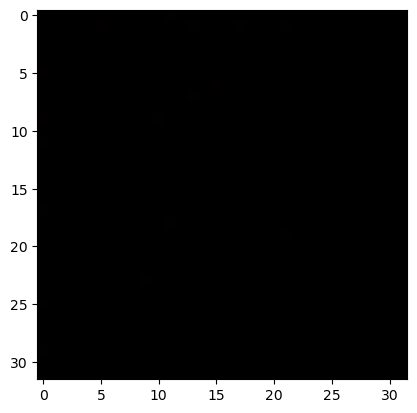

In [156]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=2)
        self.norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=2)
        self.norm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=2)
        self.norm3 = nn.BatchNorm2d(128)
        self.linear1 = nn.Linear(128*4*4, 1)


    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv3(x)
        x = self.norm3(x)
        x = F.leaky_relu(x, 0.2)
        x = x.view(-1, 128*4*4)
        x = F.dropout(x, 0.5)
        x = self.linear1(x)
        x = F.sigmoid(x)
        return x




class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.linear1 = nn.Linear(64, 64*4*4)
        self.conv1 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 3, kernel_size=5, stride=1, padding=2)


    def forward(self, x):
        x = self.linear1(x)
        x = x.view(-1, 64, 4, 4)
        x = self.conv1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv2(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv3(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv4(x)
        x = torch.tanh(x)
        return x


discriminator = Discriminator().to(device)
generator = Generator().to(device)

y = generator.forward(torch.randn(64, device=device))
plt.imshow(y[0].cpu().detach().numpy().transpose(1, 2, 0))

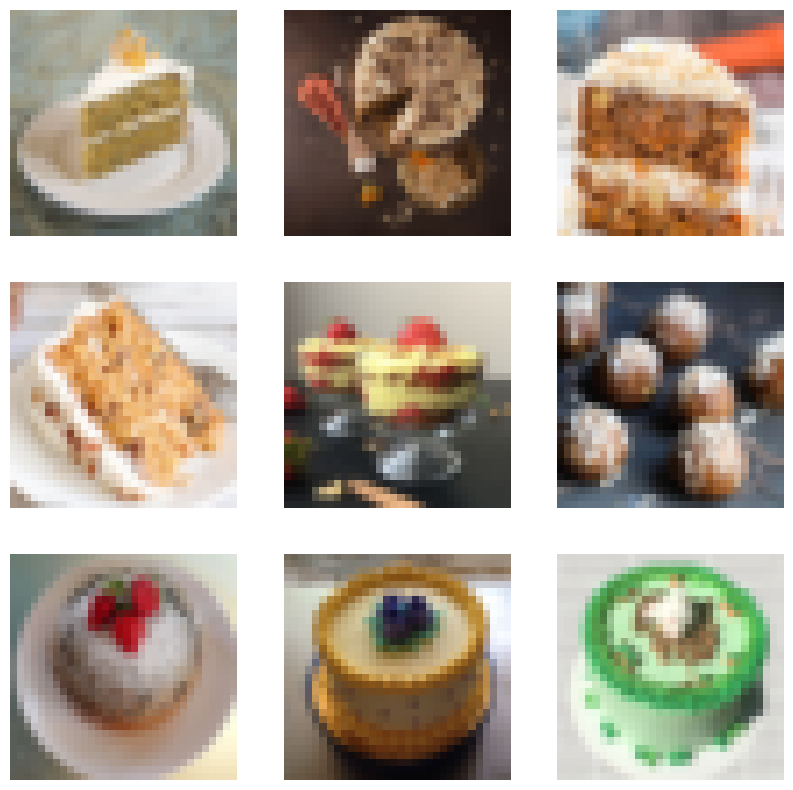

In [157]:
import os
from torchvision import transforms

transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        lambda x: x * 2 - 1,
    ]
)

true_images = []
for f in os.listdir("crawled_cakes"):
    img = Image.open(os.path.join("crawled_cakes", f))
    img = transform(img)
    true_images.append(img)

true_images = torch.stack(true_images)
true_images.shape

fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(
            true_images[i * 3 + j].detach().numpy().transpose(1, 2, 0) / 2 + 0.5
        )
        ax[i, j].axis("off")

true_images_dataset = true_images.to(device)



In [158]:
class Minimodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(2, 2)
        self.lin2 = nn.Linear(2, 2)

    def forward(self, x):
        x = self.lin(x)
        x = self.lin2(x)
        return x

minimodel = Minimodel()
input_val = torch.randn(10, 2)
loss_fn = lambda x: ((x - 42) ** 2).sum()
optimizer = torch.optim.SGD(minimodel.lin.parameters(), lr=0.01)

for i in range(20):
    optimizer.zero_grad()
    pred = minimodel(input_val)
    loss = loss_fn(pred)

    loss.backward()

    optimizer.step()

    print(pred)
    print("Loss:", loss.item())

tensor([[-0.9986,  0.0294],
        [-0.7848, -0.0892],
        [ 0.0291, -0.5414],
        [-1.0207,  0.0413],
        [-0.9977,  0.0289],
        [-0.5894, -0.1978],
        [-0.1625, -0.4346],
        [-0.4510, -0.2740],
        [-0.8272, -0.0667],
        [-0.3527, -0.3287]], grad_fn=<AddmmBackward0>)
Loss: 35956.76171875
tensor([[-0.2457, -0.4497],
        [ 0.2193, -0.7255],
        [ 2.5535, -2.1328],
        [-0.0726, -0.5613],
        [-0.2729, -0.4324],
        [ 0.8259, -1.0926],
        [ 1.8006, -1.6727],
        [ 0.8145, -1.0733],
        [ 0.7713, -1.0789],
        [ 1.1095, -1.2515]], grad_fn=<AddmmBackward0>)
Loss: 35556.0390625
tensor([[ 0.4358, -0.8778],
        [ 1.0775, -1.2576],
        [ 4.5017, -3.3124],
        [ 0.7542, -1.0772],
        [ 0.3878, -0.8479],
        [ 1.9800, -1.8008],
        [ 3.3420, -2.6093],
        [ 1.8523, -1.7097],
        [ 2.0707, -1.8774],
        [ 2.2885, -1.9720]], grad_fn=<AddmmBackward0>)
Loss: 35252.703125
tensor([[ 1.0549, -

In [159]:
def discriminator_batch():
    indices = torch.randint(0, true_images_dataset.shape[0], (16,), device=device)
    true_images = true_images_dataset[indices]

    generated_images = generator.forward(torch.randn(16, 64, device=device))

    batch = torch.cat([true_images, generated_images])
    labels = torch.cat([torch.ones(16), torch.zeros(16)]).to(device)
    random_noise = torch.rand(32, device=device)*0.1-0.05
    labels = labels + random_noise
    return batch, labels

batch, labels = discriminator_batch()
print(batch.shape, labels.shape)
pred = discriminator(batch)


torch.Size([32, 3, 32, 32]) torch.Size([32])


In [160]:
pred

tensor([[0.5464],
        [0.6194],
        [0.5911],
        [0.3767],
        [0.6057],
        [0.3628],
        [0.8549],
        [0.9035],
        [0.3217],
        [0.5632],
        [0.3852],
        [0.8047],
        [0.5467],
        [0.7979],
        [0.7256],
        [0.4924],
        [0.7481],
        [0.3668],
        [0.5066],
        [0.6186],
        [0.6653],
        [0.7839],
        [0.6633],
        [0.1031],
        [0.4368],
        [0.5323],
        [0.5462],
        [0.5299],
        [0.5624],
        [0.4581],
        [0.5095],
        [0.4583],
        [0.5483],
        [0.5117],
        [0.4939],
        [0.4631],
        [0.5631],
        [0.5441],
        [0.5471],
        [0.4443],
        [0.5195],
        [0.4657],
        [0.6423],
        [0.5023],
        [0.5547],
        [0.5823],
        [0.5504],
        [0.5425],
        [0.5797],
        [0.5207]], device='cuda:0', grad_fn=<SigmoidBackward0>)